In [1]:

import gc
import re
import cv2
import sys
import glob
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style
import tensorflow as tf

from tqdm  import tqdm
from keras import backend as K
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
#from keras.engine        import Layer, InputSpec
from keras.applications  import MobileNetV2, Xception, ResNet50, VGG16, EfficientNetB3
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
#from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input, decode_predictions
import os
import glob

SEED = 123
def set_seed(seed=48):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(SEED)

2024-05-20 20:20:09.595199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 20:20:09.595315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 20:20:09.707629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data(folder):
    data = []
    for subfolder in os.listdir(folder):
        path = os.path.join(folder, subfolder)
        for img in os.listdir(path):
            data.append((os.path.join(path, img), subfolder))
    return pd.DataFrame(data, columns=['image', 'label'])

TRAIN = load_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
VAL = load_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')
TEST = load_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')

In [3]:
TRAIN.head()

,image,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [4]:
# Check the length of the data, each set
print('Train data:', TRAIN.shape)
print('Validation data:', VAL.shape)
print('Test data:', TEST.shape)

Train data: (5216, 2)
Validation data: (16, 2)
Test data: (624, 2)


In [5]:
# Shuffling the dataset so the labels are not clearly separated
def shuffle(data):
    return data.sample(frac=1, random_state=SEED)

TRAIN = shuffle(TRAIN)
VAL = shuffle(VAL)
TEST = shuffle(TEST)

In [6]:
# Joining the Train and Validation  dataframes and split them again
# As the validation only has 16 observations.
ALL = pd.concat([TRAIN, VAL], ignore_index=True)
ALL = shuffle(ALL)

NORMAL_UNB = TRAIN['label'].value_counts()[1] + 1
TRAIN, VAL = train_test_split(ALL, test_size=0.2, stratify = ALL['label'], random_state=SEED)
TRAIN = pd.concat([TRAIN[TRAIN['label'] == 'NORMAL'], TRAIN[TRAIN['label'] == 'PNEUMONIA'].sample((NORMAL_UNB), random_state=SEED)], ignore_index=True)
TRAIN = shuffle(TRAIN)
del ALL, NORMAL_UNB

/tmp/ipykernel_24/3890510930.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NORMAL_UNB = TRAIN['label'].value_counts()[1] + 1


In [7]:
VAL['label'].value_counts()

label
PNEUMONIA    777
NORMAL       270
Name: count, dtype: int64

In [8]:
TRAIN['label'].value_counts(normalize=True)

label
PNEUMONIA    0.554316
NORMAL       0.445684
Name: proportion, dtype: float64

In [9]:
PNEUMONIA = TRAIN['label'].value_counts()[0]
NORMAL = TRAIN['label'].value_counts()[1]
print(f'There are {PNEUMONIA} cases of pneumonia and {NORMAL} normal cases in the training set.')

There are 1342 cases of pneumonia and 1079 normal cases in the training set.


/tmp/ipykernel_24/2266612555.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PNEUMONIA = TRAIN['label'].value_counts()[0]
/tmp/ipykernel_24/2266612555.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NORMAL = TRAIN['label'].value_counts()[1]


In [10]:
# To balance the dataset, class weights can be made
# As done in the Tensorflow documentation, with W1 being PNEUMONIA

W0 = (1 / NORMAL)*(len(TRAIN))/2.0
W1 = (1 / PNEUMONIA)*(len(TRAIN))/2.0 

CW = {0: W0, 1: W1}
print(f'Class weight for class 0: {W0}')
print(f'Class weight for class 1: {W1}')


Class weight for class 0: 1.1218721037998147
Class weight for class 1: 0.9020119225037257


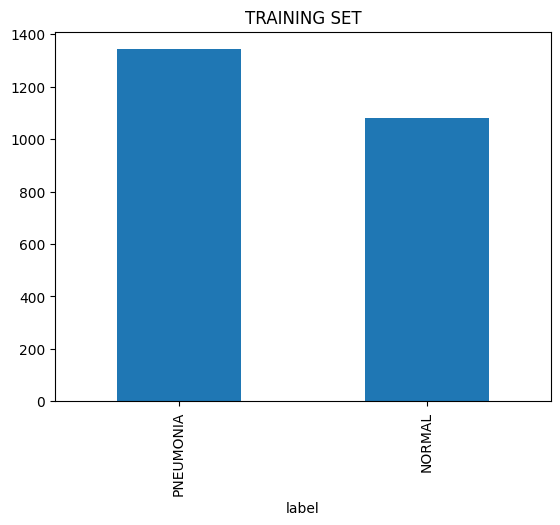

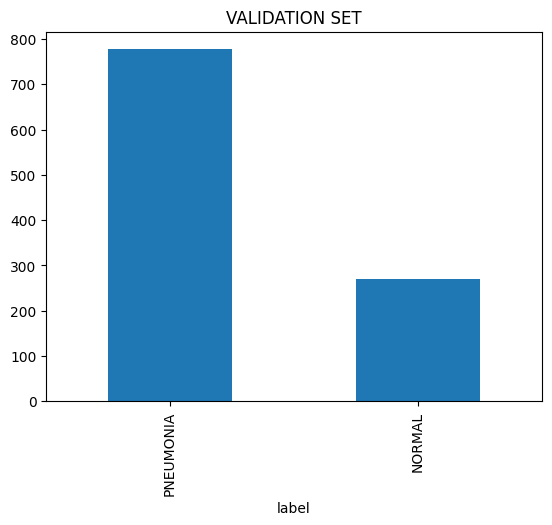

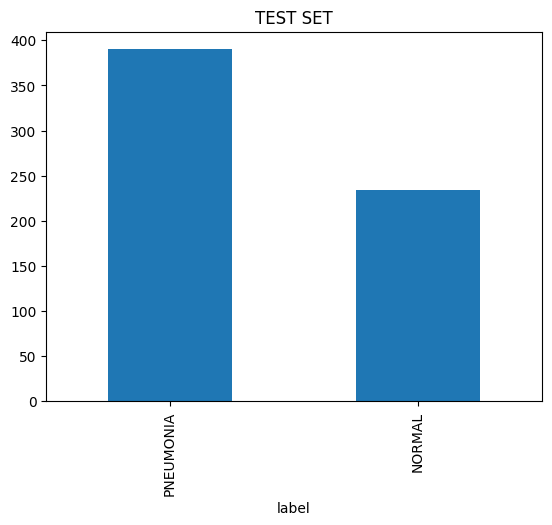

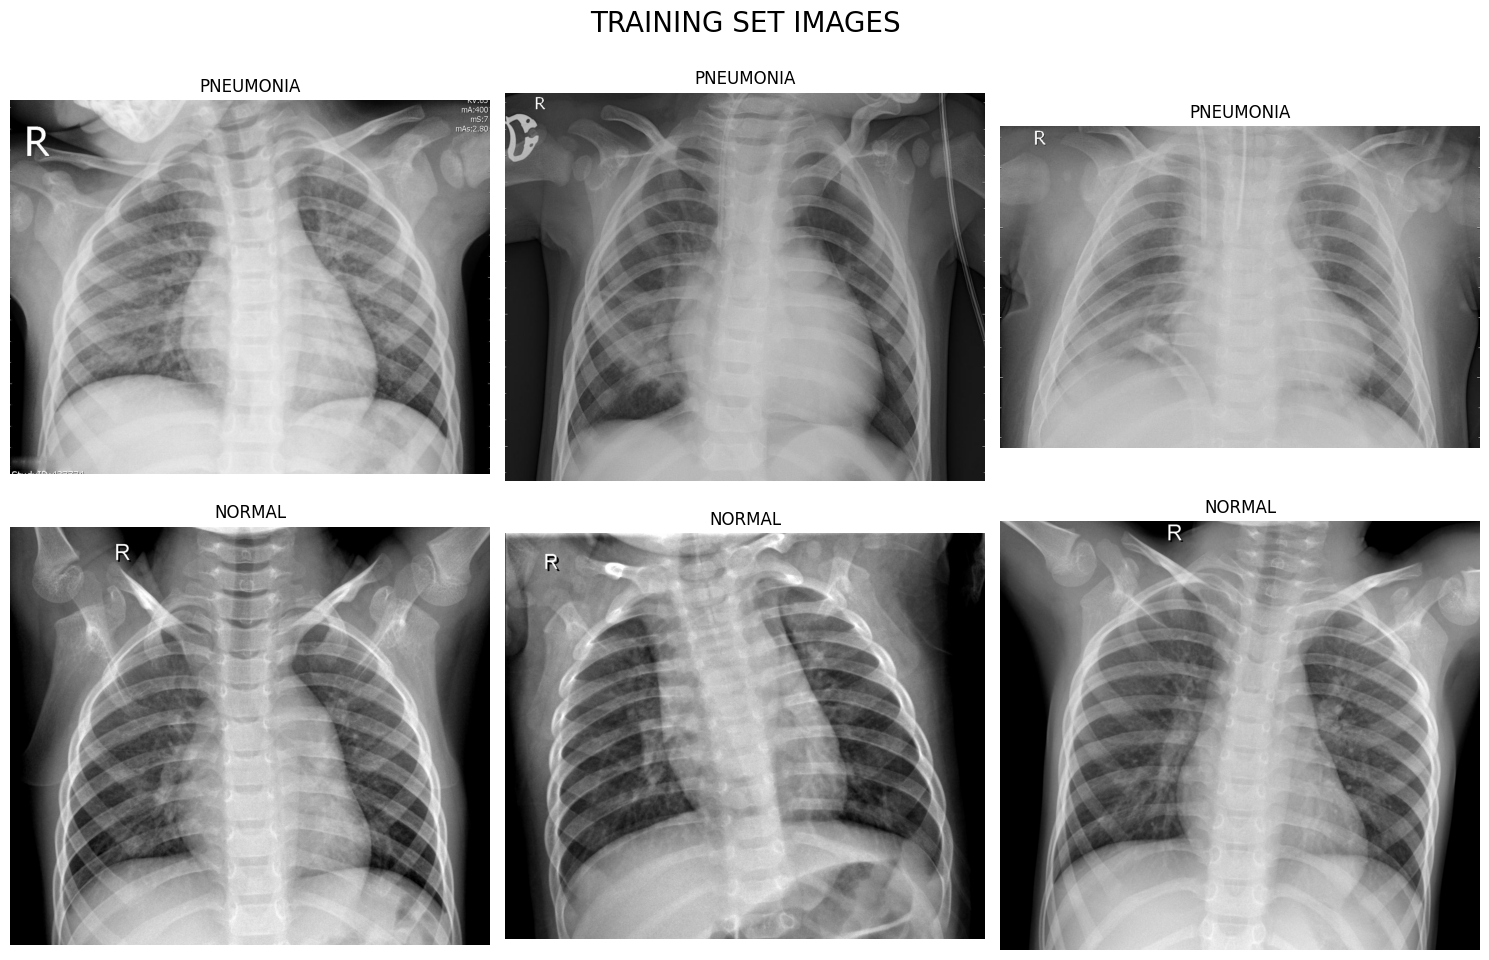

In [11]:
# Function to plot the class distribution
def plot_class_distribution(data, title):
    data['label'].value_counts().plot(kind='bar')
    plt.title(title)
    plt.show()

plot_class_distribution(TRAIN, 'TRAINING SET')
plot_class_distribution(VAL, 'VALIDATION SET')
plot_class_distribution(TEST, 'TEST SET')

# See 3 images from each class, 3 Normal and 3 Pneumonia
def plot_images(data, title):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=20)
    PNEUMONIA_images = data[data['label'] == 'PNEUMONIA']['image'].sample(3).tolist()   
    NORMAL_images = data[data['label'] == 'NORMAL']['image'].sample(3).tolist()
    images = PNEUMONIA_images + NORMAL_images
    labels = ['PNEUMONIA']*3 + ['NORMAL']*3
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(cv2.imread(images[i]), cmap='gray')
        ax.set_title(labels[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    

plot_images(TRAIN, 'TRAINING SET IMAGES')


In [12]:
# Storing the new dataframes in a folder structure similar to the original sets
def create_folders(data, folder):
    for subfolder in data['label'].unique():
        os.makedirs(os.path.join(folder, subfolder), exist_ok=True)
    for i, row in data.iterrows():
        os.symlink(row['image'], os.path.join(folder, row['label'], row['image'].split('/')[-1]))

create_folders(TRAIN, 'data/train')
create_folders(VAL, 'data/val')
create_folders(TEST, 'data/test')

# If not using ML models
del TRAIN, VAL, TEST

In [13]:
def get_xy(data, colx, coly):
    return data[colx], data[coly]

#X_TRAIN, Y_TRAIN = get_xy(TRAIN, 'image', 'label')
#X_VAL, Y_VAL = get_xy(VAL, 'image', 'label')
#X_TEST, Y_TEST = get_xy(TEST, 'image', 'label')


In [14]:
#img = cv2.imread(X_TRAIN[5])
#display(img.shape)

#plt.imshow(img)

In [15]:
def get_data(paths, doResize = True, size = (224,224),normalise = True, grey = True, interp = cv2.INTER_LINEAR, flat = False):
    data = pd.DataFrame()
    for i, path in tqdm(enumerate(paths)):
        img = cv2.imread(path)
                    
        if doResize:
            img = cv2.resize(img, size, interpolation = interp)
            
        if normalise:
            img = cv2.normalize(img, None, alpha = 0, beta = 255)
        
        if grey:
            img = img[:,:,0] # remove channels
        
        if flat:
            img = pd.DataFrame(img.flatten()).T
            
        data = pd.concat([data, img])
    
    return data

#X_TRAIN_T = get_data(X_TRAIN, flat = True)
#X_VAL_T = get_data(X_VAL, flat = True)
#X_TEST_T = get_data(X_TEST, flat = True)

In [16]:
# Using normal machine learning 
#!pip install lazypredict

#import lazypredict
#from lazypredict.Supervised import LazyClassifier

#LC = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#MODELS,PRED = LC.fit(X_TRAIN_T, X_VAL_T, Y_TRAIN, Y_VAL)
#MODELS

In [17]:
# Create ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

#ETC = ExtraTreesClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
#ETC.fit(X_TRAIN_T, Y_TRAIN)

# Predict
#PREDS_ETC = ETC.predict(X_TEST_T)

In [18]:
#from sklearn.metrics import accuracy_score
#accuracy_score(Y_TEST, PREDS_ETC)

# CNN

In [19]:
PATH = '/kaggle/working/data/'
BATCHSIZE = 64
SIZE = (224, 224)
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Using Image Datasets to optimise training 
TRAIN = tf.keras.preprocessing.image_dataset_from_directory(
    PATH + 'train',
    color_mode='rgb', # BW saves memory but does not often work with Trasnfer Learning 
    batch_size=BATCHSIZE,
    image_size=SIZE,
    shuffle=True,
    seed=SEED,

    verbose=True
)

VAL = tf.keras.preprocessing.image_dataset_from_directory(
    PATH + 'val',
    color_mode='rgb', 
    batch_size=BATCHSIZE,
    image_size=SIZE,
    shuffle=True,
    seed=SEED,

    verbose=True
)


TEST = tf.keras.preprocessing.image_dataset_from_directory(
    PATH + 'test',
    color_mode='rgb',
    batch_size=BATCHSIZE,
    image_size=SIZE,
    shuffle=True,
    seed=SEED,
    verbose=True
)

# Ensure that the images have float values and that the labels are one hot encoded
def to_float(image, label):
    return (image/255.0), label

def to_binary(image, label):
    return image, tf.cast(label, tf.float32)

TRAIN = TRAIN.map(to_float).prefetch(buffer_size=AUTOTUNE)
VAL = VAL.map(to_float).prefetch(buffer_size=AUTOTUNE)
TEST = TEST.map(to_float).prefetch(buffer_size=AUTOTUNE)




Found 2421 files belonging to 2 classes.
Found 1047 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [20]:
LR = 1e-3
DROPOUT = 0.25
CLASSES = 1
EPOCHS = 22
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Recall(name='recall')]

In [21]:

def denseBlock(units, dropout):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation='relu'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout))
    
    return block

def convolBlock(filters):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'))
    block.add(tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
    
    return block

def augmentBlock():
    block = tf.keras.Sequential()
    #block.add(keras.layers.Rescaling(1./255))
    block.add(keras.layers.RandomRotation(0.15))
    block.add(keras.layers.RandomZoom(0.12))
    block.add(keras.layers.RandomBrightness(0.13))
    block.add(keras.layers.RandomContrast(0.12))
    
    return block





CNN = tf.keras.Sequential()
CNN.add(tf.keras.Input(shape=SIZE + (3,)))
#CNN.add(augmentBlock())
CNN.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'))
CNN.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'))
CNN.add(tf.keras.layers.MaxPool2D())
CNN.add(convolBlock(32))
CNN.add(convolBlock(64))
CNN.add(convolBlock(128))
CNN.add(tf.keras.layers.Dropout(0.25))
CNN.add(convolBlock(256))
CNN.add(tf.keras.layers.Dropout(0.25))
CNN.add(tf.keras.layers.GlobalMaxPooling2D())
CNN.add(denseBlock(512, 0.4))
CNN.add(denseBlock(256, 0.325))
CNN.add(denseBlock(128, 0.25))
CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

CNN.compile(optimizer=keras.optimizers.Adamax(0.001),
            loss='binary_crossentropy',
            metrics=METRICS)



In [22]:

def create_model(input_shape, model_name='mobilenet', n_classes=1, lr=0.0001, dropout=0.5):
    model_name = model_name.lower()
    if model_name == 'mobilenet':
        base_model = keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    elif model_name == 'inceptionresnet':
        base_model = keras.applications.InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    elif model_name == 'resnet':
        base_model = keras.applications.ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')
    elif model_name == 'convnext':
        base_model = keras.applications.ConvNeXtTiny(input_shape=input_shape, include_top=False, weights='imagenet')
        
    else:
        raise ValueError('Model not supported')
    
    base_model.trainable = False
    #for layer in base_model.layers[-15:]:
     #   if not isinstance(layer, keras.layers.BatchNormalization):
      #      layer.trainable = True

    
    model = Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    #model.add(augmentBlock())
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adamax(lr),
                  loss='binary_crossentropy',
                  metrics=METRICS)
    
    return model


In [23]:

def train_model(model, train_img_data, val_img_data, epochs=10, batch_size=32, verbose=1, name ='model'):
    checkpoint = ModelCheckpoint(f'{name}.keras', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=0.00001)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # Use the preprocess_input function from the model if it exists
    history = model.fit(train_img_data,
                        validation_data=(val_img_data),
                        epochs=epochs,
                        verbose=verbose,
                        batch_size = BATCHSIZE,
                        callbacks=[checkpoint, reduce_lr, early_stopping])#,
                        #class_weight = CW)
    
    print("Done with", model.name, "! \n")
    
    return history

In [24]:
# Create an instance of each model
CONVNEXT = create_model(input_shape=SIZE + (3,), model_name='convnext', n_classes=CLASSES, lr=LR, dropout=DROPOUT)
MOBILENET = create_model(input_shape=SIZE + (3,), model_name='mobilenet', n_classes=CLASSES, lr=LR, dropout=DROPOUT)
RESNET = create_model(input_shape=SIZE + (3,), model_name='resnet', n_classes=CLASSES, lr=LR, dropout=DROPOUT)
INCEPRESNET = create_model(input_shape=SIZE + (3,), model_name='inceptionresnet', n_classes=CLASSES, lr=LR, dropout=DROPOUT)

# Train the models
HIST_CONVNEXT = train_model(CONVNEXT, TRAIN, VAL, epochs=EPOCHS, verbose=1, name = 'ConvNext')
HIST_MOBILE = train_model(MOBILENET, TRAIN, VAL, epochs=EPOCHS, verbose=1, name = 'MobileNet')
HIST_RESNET = train_model(RESNET, TRAIN, VAL, epochs=EPOCHS, verbose=1, name = 'ResNet')
HIST_INCEPRESNET = train_model(INCEPRESNET, TRAIN, VAL, epochs=EPOCHS, verbose=1, name = 'InceptionRestNet')
HIST_CNN = train_model(CNN, TRAIN, VAL, epochs=EPOCHS, verbose=1)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/22
 1/38 ━━━━━━━━━━━━━━━━━━━━ 15:24 25s/step - accuracy: 0.3281 - loss: 1.2642 - recall: 0.2188

I0000 00:00:1716236471.347588      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716236471.382883      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236471.383336      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236471.383749      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236471.386722      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236471.387114      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236471.387637      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7666 - loss: 0.5087 - recall: 0.7335

W0000 00:00:1716236490.422360      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.422716      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.423229      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.424253      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.424684      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.425070      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.425484      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716236490.425884      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 907ms/step - accuracy: 0.7682 - loss: 0.5060 - recall: 0.7352 - val_accuracy: 0.8462 - val_loss: 0.3716 - val_recall: 0.8649 - learning_rate: 0.0010
Epoch 2/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 425ms/step - accuracy: 0.8781 - loss: 0.3101 - recall: 0.8547 - val_accuracy: 0.8510 - val_loss: 0.3600 - val_recall: 0.8468 - learning_rate: 0.0010
Epoch 3/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 430ms/step - accuracy: 0.8996 - loss: 0.2738 - recall: 0.8932 - val_accuracy: 0.8596 - val_loss: 0.3374 - val_recall: 0.8520 - learning_rate: 0.0010
Epoch 4/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 402ms/step - accuracy: 0.9180 - loss: 0.2247 - recall: 0.9110 - val_accuracy: 0.8615 - val_loss: 0.3459 - val_recall: 0.8417 - learning_rate: 0.0010
Epoch 5/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 431ms/step - accuracy: 0.9125 - loss: 0.2372 - recall: 0.9087 - val_accuracy: 0.8749 - val_loss: 0.3218 - val_recall: 0.8494 - learning_rate: 0.0010
Epoch 6/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 422ms/step - a

2024-05-20 20:43:49.727546: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.57512, expected 3.11457
2024-05-20 20:43:49.727616: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 3.34153, expected 2.88098
2024-05-20 20:43:49.727822: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.69283, expected 3.82932
2024-05-20 20:43:49.727830: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 6.5873, expected 5.72379
2024-05-20 20:43:49.727838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.24861, expected 6.3851
2024-05-20 20:43:49.727857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.89519, expected 6.03168
2024-05-20 20:43:49.727868: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.97061, expected 5.1071
2024-05-20 20:43:49.727880: E exter

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8607 - loss: 0.6015 - recall: 0.8673

2024-05-20 20:44:23.824820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.66323, expected 2.29423
2024-05-20 20:44:23.824892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.23421, expected 1.86521
2024-05-20 20:44:23.825099: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 2.7576, expected 2.17636
2024-05-20 20:44:23.825107: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 4.37983, expected 3.79859
2024-05-20 20:44:23.825115: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.23804, expected 3.6568
2024-05-20 20:44:23.825122: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.6177, expected 4.03646
2024-05-20 20:44:23.825130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.36696, expected 3.78572
2024-05-20 20:44:23.825137: E exter

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8605 - loss: 0.5975 - recall: 0.8668

2024-05-20 20:44:47.604534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.32149, expected 2.73728
2024-05-20 20:44:47.604597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.61127, expected 4.02707
2024-05-20 20:44:47.604613: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.62746, expected 4.04325
2024-05-20 20:44:47.604626: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.42537, expected 3.84117
2024-05-20 20:44:47.604644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.0296, expected 3.4454
2024-05-20 20:44:47.604665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.62796, expected 4.04375
2024-05-20 20:44:47.604676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.28162, expected 3.69742
2024-05-20 20:44:47.604686: E external/local_xla/xla/se

38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8603 - loss: 0.5938 - recall: 0.8664 - val_accuracy: 0.7421 - val_loss: 0.8851 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.8975 - loss: 0.2433 - recall: 0.9083 - val_accuracy: 0.7421 - val_loss: 1.5158 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 348ms/step - accuracy: 0.9269 - loss: 0.1900 - recall: 0.9213 - val_accuracy: 0.7421 - val_loss: 1.6932 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - accuracy: 0.9385 - loss: 0.1396 - recall: 0.9409 - val_accuracy: 0.7421 - val_loss: 1.7567 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step - accuracy: 0.9517 - loss: 0.1290 - recall: 0.9551 - val_accuracy: 0.7421 - val_loss: 1.7202 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accu

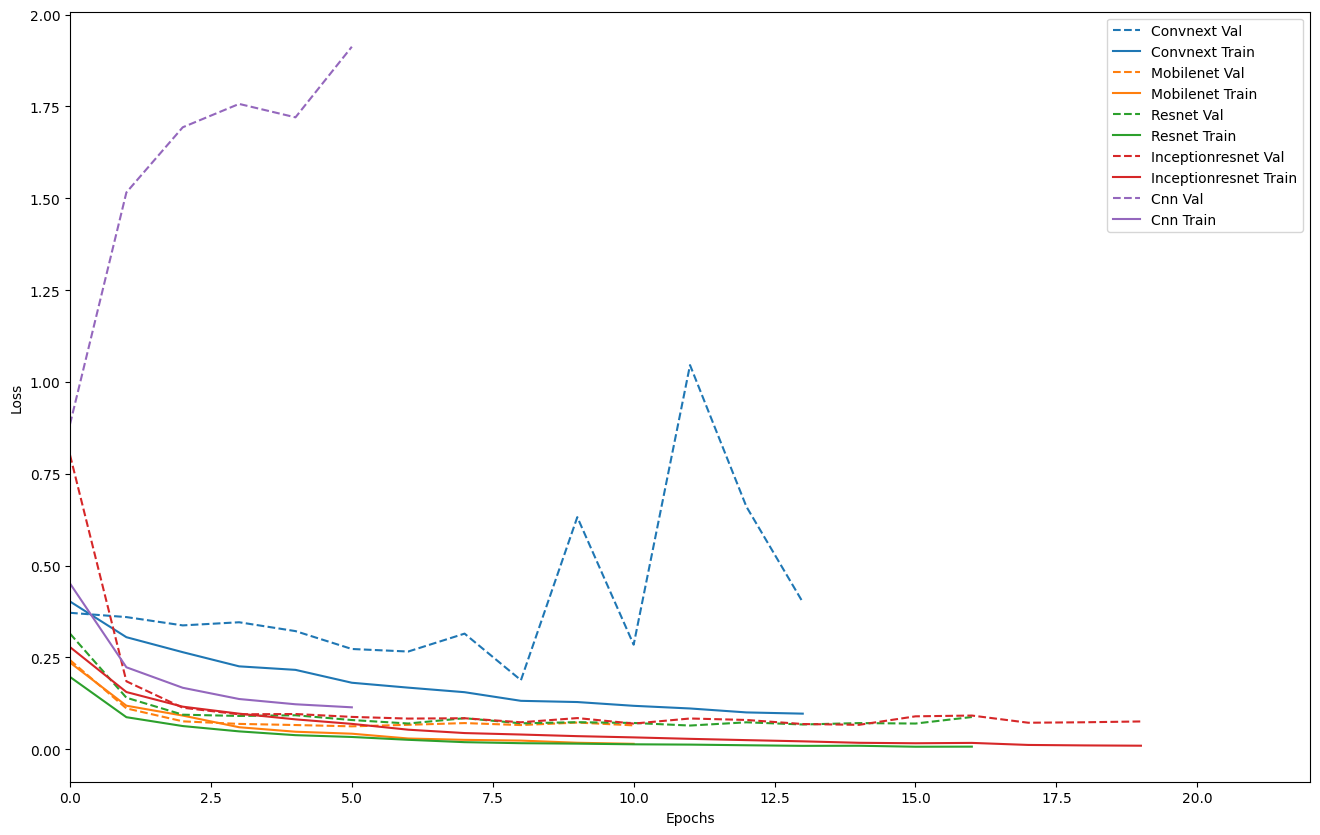

In [25]:
# Compare the models

def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,EPOCHS])
    plt.show()
    



plot_history([('ConvNext', HIST_CONVNEXT),  ('MobileNet', HIST_MOBILE), ('ResNet', HIST_RESNET), ('InceptionResNet', HIST_INCEPRESNET), ('CNN', HIST_CNN)], key='loss')

In [26]:
# Check the accuracy of the model on each set

def get_accuracy(model, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    # Predictions
    Y_train_pred = model.predict(X_TRAIN)
    Y_val_pred = model.predict(X_VAL)
    Y_test_pred = model.predict(X_TEST)
    
    Y_train_pred = (Y_train_pred > 0.5).astype(int)
    Y_val_pred = (Y_val_pred > 0.5).astype(int)
    Y_test_pred = (Y_test_pred > 0.5).astype(int)

    # Calculate the accuracy
    train_acc = accuracy_score(Y_TRAIN, Y_train_pred)
    val_acc = accuracy_score(Y_VAL, Y_val_pred)
    test_acc = accuracy_score(Y_TEST, Y_test_pred)
    
    
    return train_acc, val_acc, test_acc

In [27]:
MODELS = [CONVNEXT, MOBILENET, RESNET, INCEPRESNET, CNN]
TRAIN_ACCS, VAL_ACCS, TEST_ACCS, TRAIN_RECALL, VAL_RECALL, TEST_RECALL, TRAIN_LOSS, VAL_LOSS, TEST_LOSS = [], [], [], [], [], [], [], [], []



for model in MODELS:
    # Get the metrics from the model for each set with model.evaluate
    train_loss, train_acc, train_recall = model.evaluate(TRAIN, verbose=0)
    val_loss, val_acc, val_recall = model.evaluate(VAL, verbose=0)
    test_loss, test_acc, test_recall = model.evaluate(TEST, verbose=1)

    TRAIN_ACCS.append(train_acc)
    VAL_ACCS.append(val_acc)
    TEST_ACCS.append(test_acc)

    TRAIN_RECALL.append(train_recall)
    VAL_RECALL.append(val_recall)
    TEST_RECALL.append(test_recall)

    TRAIN_LOSS.append(train_loss)
    VAL_LOSS.append(val_loss)
    TEST_LOSS.append(test_loss)



ACCURACY = pd.DataFrame({'Model': ['CONVNEXT', 'MOBILENET', 'RESNET', 'INCEPRESNET', 'CNN'],
                         'Train Accuracy': TRAIN_ACCS,
                         'Validation Accuracy': VAL_ACCS,
                         'Test Accuracy': TEST_ACCS,
                         'Train Recall': TRAIN_RECALL,
                         'Validation Recall': VAL_RECALL,
                         'Test Recall': TEST_RECALL,
                         'Train Loss': TRAIN_LOSS,
                         'Validation Loss': VAL_LOSS,
                         'Test Loss': TEST_LOSS})

ACCURACY

W0000 00:00:1716237981.707042      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.707400      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.707883      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.708934      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.709339      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.709740      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.710123      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237981.710497      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 640ms/step - accuracy: 0.8371 - loss: 0.4200 - recall: 0.8657


W0000 00:00:1716237994.551731      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237994.552199      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716237994.552672      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 712ms/step - accuracy: 0.8682 - loss: 0.4376 - recall: 0.9939
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8730 - loss: 0.4605 - recall: 0.9661
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8184 - loss: 0.6514 - recall: 0.9852
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6663 - loss: 2.4962 - recall: 1.0000

2024-05-20 20:48:35.882440: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.74976, expected 3.27289
2024-05-20 20:48:35.882506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.84483, expected 2.36796
2024-05-20 20:48:35.882515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 3.42888, expected 2.95201
2024-05-20 20:48:35.882523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.40858, expected 2.93172
2024-05-20 20:48:35.882531: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 101: 3.72985, expected 3.25298
2024-05-20 20:48:35.882539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 2.93116, expected 2.4543
2024-05-20 20:48:35.882547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.75945, expected 3.28258
2024-05-20 20:48:35.882555: E external/local_xl

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 625ms/step - accuracy: 0.6562 - loss: 2.5725 - recall: 1.0000


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Recall,Validation Recall,Test Recall,Train Loss,Validation Loss,Test Loss
0,CONVNEXT,0.897563,0.839542,0.825321,0.815946,0.785071,0.858974,0.249133,0.400573,0.457017
1,MOBILENET,1.000000,0.979943,0.870192,1.000000,0.979408,0.992308,0.006223,0.065258,0.410341
2,RESNET,0.999587,0.971347,0.868590,1.000000,0.970399,0.979487,0.002535,0.087976,0.480371
3,INCEPRESNET,0.999587,0.977077,0.838141,1.000000,0.980695,0.987179,0.005810,0.075912,0.562717
4,CNN,0.554316,0.742120,0.625000,1.000000,1.000000,1.000000,3.293352,1.915337,2.806094


In [28]:

# Create the ensemble model
def create_ensemble(input_shape):
    # Define the input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    train_layer = 12

    # Load and configure the ResNet model
    resnet_model = keras.applications.ResNet152V2(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet_model.trainable = False
    for layer in resnet_model.layers[-train_layer:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

    # Load and configure the MobileNet model
    mobilenet_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
    mobilenet_model.trainable = False
    for layer in mobilenet_model.layers[-train_layer:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True
            
    inception_model = keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
    inception_model.trainable = False
    for layer in inception_model.layers[-train_layer:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

    # Flatten the outputs of both models
    resnet_output = Flatten()(resnet_model.output)
    mobilenet_output = Flatten()(mobilenet_model.output)
    inception_output = Flatten()(inception_model.output)
    DR = 0.3
    units = 128

    # Add two blocks of Dense, BatchNormalization, and Dropout layers to each model's output
    resnet_output = Dense(units, activation='relu')(resnet_output)
    resnet_output = BatchNormalization()(resnet_output)
    resnet_output = Dropout(DR)(resnet_output)
    resnet_output = Dense(int(units/2), activation='relu')(resnet_output)
    resnet_output = BatchNormalization()(resnet_output)
    resnet_output = Dropout(DR)(resnet_output)
    resnet_output = Dense(1, activation='sigmoid')(resnet_output)

    mobilenet_output = Dense(units, activation='relu')(mobilenet_output)
    mobilenet_output = BatchNormalization()(mobilenet_output)
    mobilenet_output = Dropout(DR)(mobilenet_output)
    mobilenet_output = Dense(int(units/2), activation='relu')(mobilenet_output)
    mobilenet_output = BatchNormalization()(mobilenet_output)
    mobilenet_output = Dropout(DR)(mobilenet_output)
    mobilenet_output = Dense(1, activation='sigmoid')(mobilenet_output)
    
    inception_output = Dense(units, activation='relu')(inception_output)
    inception_output = BatchNormalization()(inception_output)
    inception_output = Dropout(DR)(inception_output)
    inception_output = Dense(int(units/2), activation='relu')(inception_output)
    inception_output = BatchNormalization()(inception_output)
    inception_output = Dropout(DR)(inception_output)
    inception_output = Dense(1, activation='sigmoid')(inception_output)

    # Average the outputs of the two models
    #averaged_output = keras.layers.Average()([resnet_output, mobilenet_output, inception_output])

    # Add a final Dense layer for the prediction
    #predictions = Dense(1, activation='sigmoid')(averaged_output)

    # Create the ensemble model
    
    # Assign weights to each model's output
    mobilenet_weight = 0.15  
    resnet_weight = 0.0     
    inception_weight = 0.85  

    # Weighted average of the outputs
    weighted_average_output = keras.layers.add([
        mobilenet_output * mobilenet_weight,
        resnet_output * resnet_weight,
        inception_output * inception_weight
    ])
    
    ensemble_model = Model(inputs=inputs, outputs=weighted_average_output)

    # Compile the ensemble model
    ensemble_model.compile(optimizer=keras.optimizers.Adamax(LR), loss='binary_crossentropy', metrics = METRICS)
    
    return ensemble_model
    

ENSEMBLE = create_ensemble(input_shape=SIZE + (3,))
print('Ensemble compiled.')

/tmp/ipykernel_24/3375922476.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


Ensemble compiled.


In [29]:
HIST_ENSEMBLE = train_model(ENSEMBLE, TRAIN, VAL, epochs=EPOCHS, verbose=1)

Epoch 1/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.7826 - loss: 0.3041 - recall: 0.9236 - val_accuracy: 0.9255 - val_loss: 0.1764 - val_recall: 0.9060 - learning_rate: 0.0010
Epoch 2/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 760ms/step - accuracy: 0.9626 - loss: 0.0949 - recall: 0.9637 - val_accuracy: 0.9542 - val_loss: 0.1472 - val_recall: 0.9936 - learning_rate: 0.0010
Epoch 3/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 792ms/step - accuracy: 0.9824 - loss: 0.0552 - recall: 0.9815 - val_accuracy: 0.9780 - val_loss: 0.1024 - val_recall: 0.9923 - learning_rate: 0.0010
Epoch 4/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 756ms/step - accuracy: 0.9888 - loss: 0.0390 - recall: 0.9875 - val_accuracy: 0.9799 - val_loss: 0.0955 - val_recall: 0.9910 - learning_rate: 0.0010
Epoch 5/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 606ms/step - accuracy: 0.9941 - loss: 0.0274 - recall: 0.9957 - val_accuracy: 0.9752 - val_loss: 0.1049 - val_recall: 0.9949 - learning_rate: 0.0010
Epoch 6/22
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 609ms

In [30]:
ENSEMBLE.evaluate(TRAIN, verbose=1)
ENSEMBLE.evaluate(VAL, verbose=1)
ENSEMBLE.evaluate(TEST, verbose=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 755ms/step - accuracy: 0.9994 - loss: 0.0027 - recall: 0.9990
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9713 - loss: 0.0709 - recall: 0.9647
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8926 - loss: 0.4563 - recall: 0.9896


[0.5455642342567444, 0.870192289352417, 0.9820512533187866]

In [31]:
# Retrieve the images and respective labels from the test set
def RetrieveData(data):
    X = []
    Y = []
    for x, y in data:
        X.append(x)
        Y.append(y)
    return np.concatenate(X, axis=0), np.concatenate(Y, axis=0)

X_TRAIN, Y_TRAIN = RetrieveData(TRAIN)
X_VAL, Y_VAL = RetrieveData(VAL)
X_TEST, Y_TEST = RetrieveData(TEST)



In [32]:
# Check the performance on the Train, Validation and Test set and display the confusion matrix and ROC curve

from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools

def get_metrics(model, X_train, X_val, X_test, Y_train, Y_val, Y_test):
    # Predictions
    Y_train_pred = model.predict(X_train)
    Y_val_pred = model.predict(X_val)
    Y_test_pred = model.predict(X_test)
    
    Y_train_pred = (Y_train_pred > 0.5).astype(int)
    Y_val_pred = (Y_val_pred > 0.5).astype(int)
    Y_test_pred = (Y_test_pred > 0.5).astype(int)
    
    # Confusion matrix
    train_cm = confusion_matrix(Y_train, Y_train_pred)
    val_cm = confusion_matrix(Y_val, Y_val_pred)
    test_cm = confusion_matrix(Y_test, Y_test_pred)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(Y_train, Y_train_pred)
    roc_auc = auc(fpr, tpr)
    
    fpr_val, tpr_val, _ = roc_curve(Y_val, Y_val_pred)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    fpr_test, tpr_test, _ = roc_curve(Y_test, Y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    return train_cm, val_cm, test_cm, fpr, tpr, roc_auc, fpr_val, tpr_val, roc_auc_val, fpr_test, tpr_test, roc_auc_test

# Display the confusion matrix and ROC curve

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot ROC curve

def plot_roc_curve(fpr, tpr, roc_auc, fpr_val, tpr_val, roc_auc_val, fpr_test, tpr_test, roc_auc_test):

    plt.figure(figsize=(16, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr_val, tpr_val, color='red', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()





76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 656ms/step


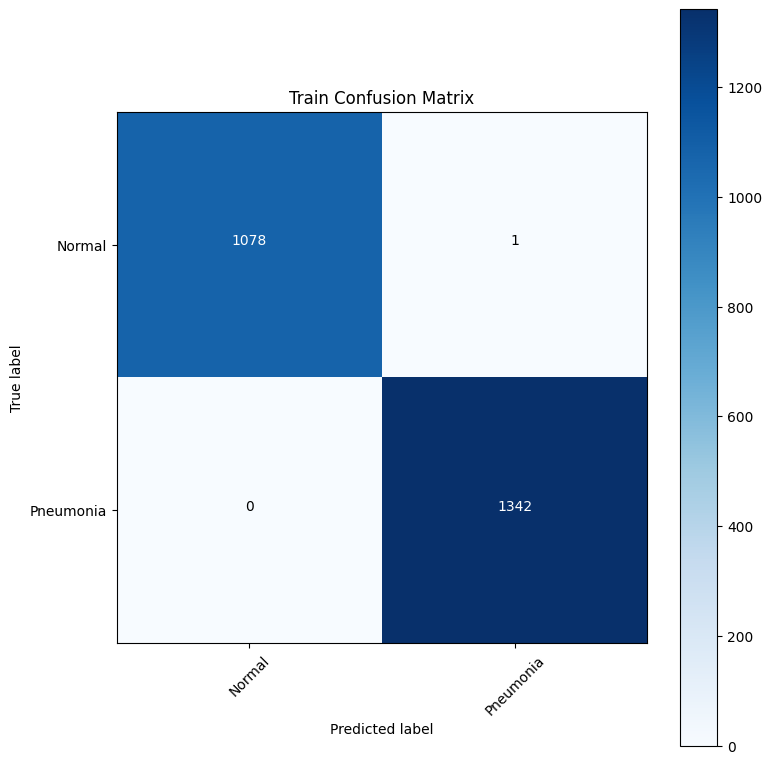

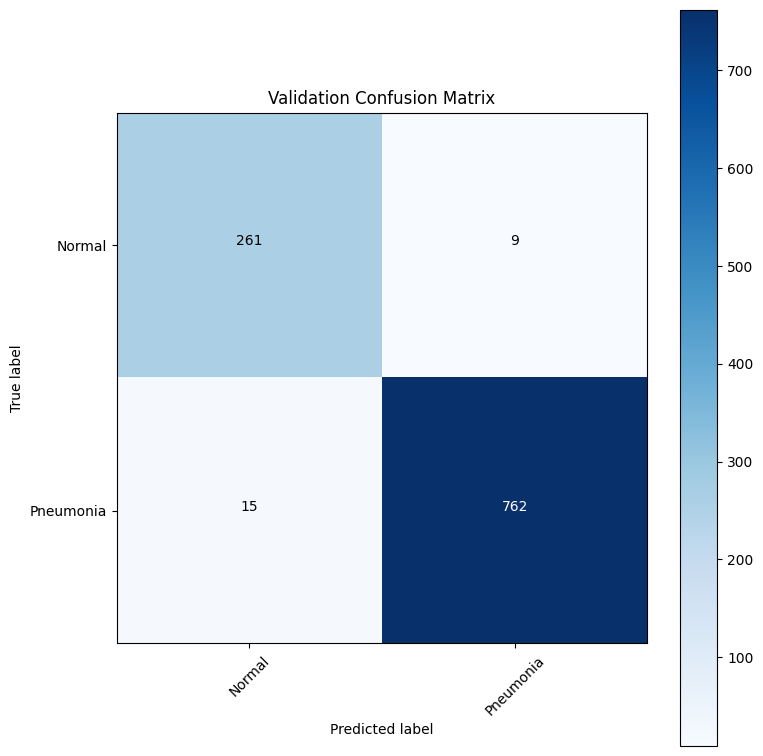

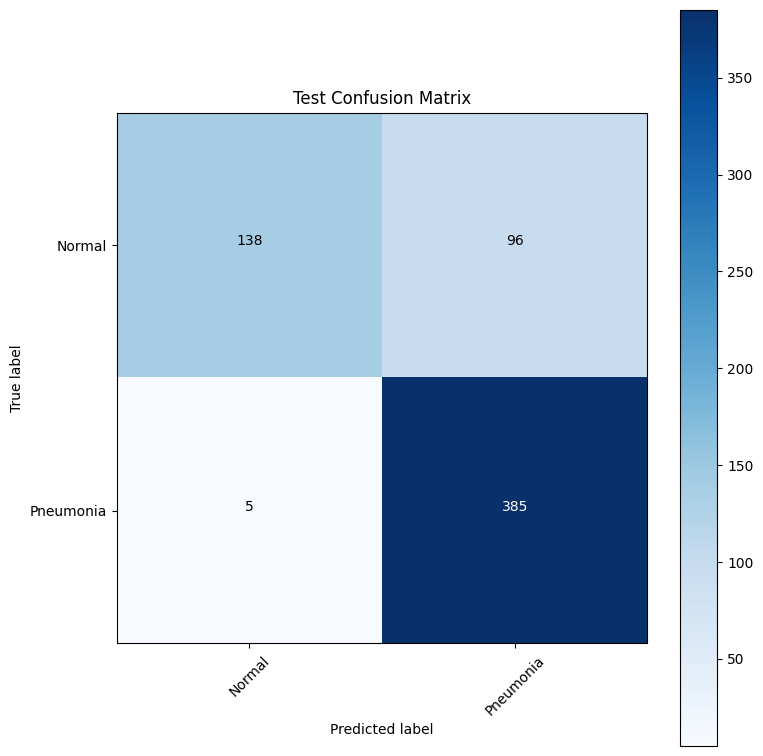

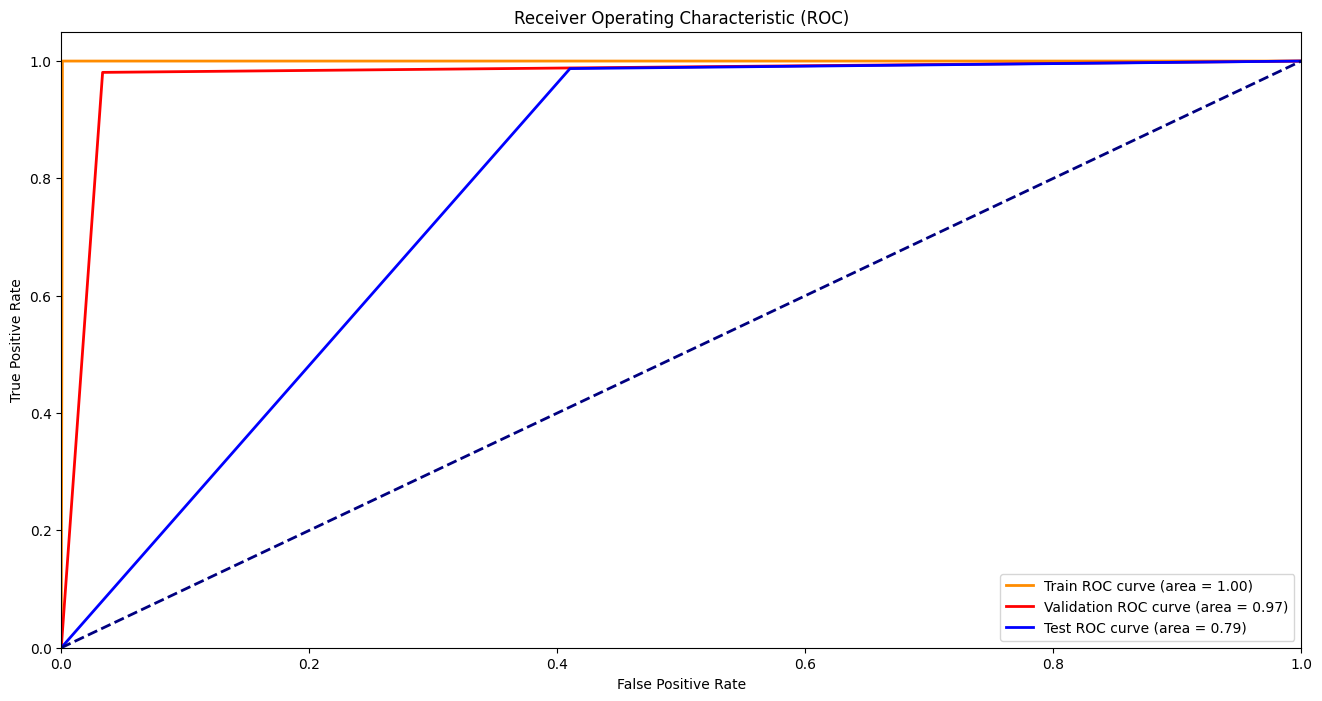

In [33]:
TRAIN_CM, VAL_CM, TEST_CM, FPR, TPR, ROC_AUC, FPR_VAL, TPR_VAL, ROC_AUC_VAL, FPR_TEST, TPR_TEST, ROC_AUC_TEST = get_metrics(INCEPRESNET, X_TRAIN, X_VAL, X_TEST, Y_TRAIN, Y_VAL, Y_TEST)
# Display the confusion matrix and ROC curve
plot_confusion_matrix(TRAIN_CM, ['Normal', 'Pneumonia'], title='Train Confusion Matrix')
plot_confusion_matrix(VAL_CM, ['Normal', 'Pneumonia'], title='Validation Confusion Matrix')
plot_confusion_matrix(TEST_CM, ['Normal', 'Pneumonia'], title='Test Confusion Matrix')

plot_roc_curve(FPR, TPR, ROC_AUC, FPR_VAL, TPR_VAL, ROC_AUC_VAL, FPR_TEST, TPR_TEST, ROC_AUC_TEST)


76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 642ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


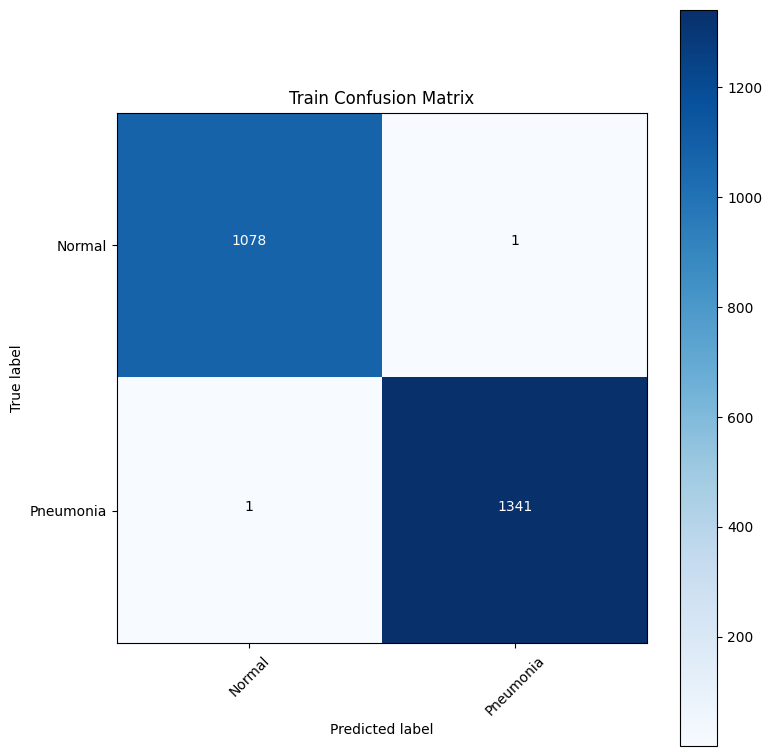

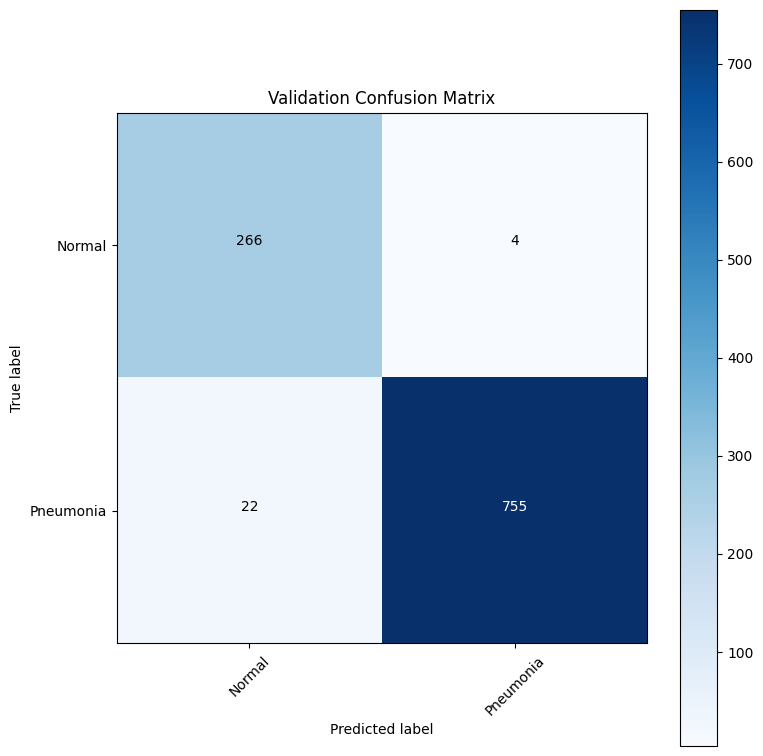

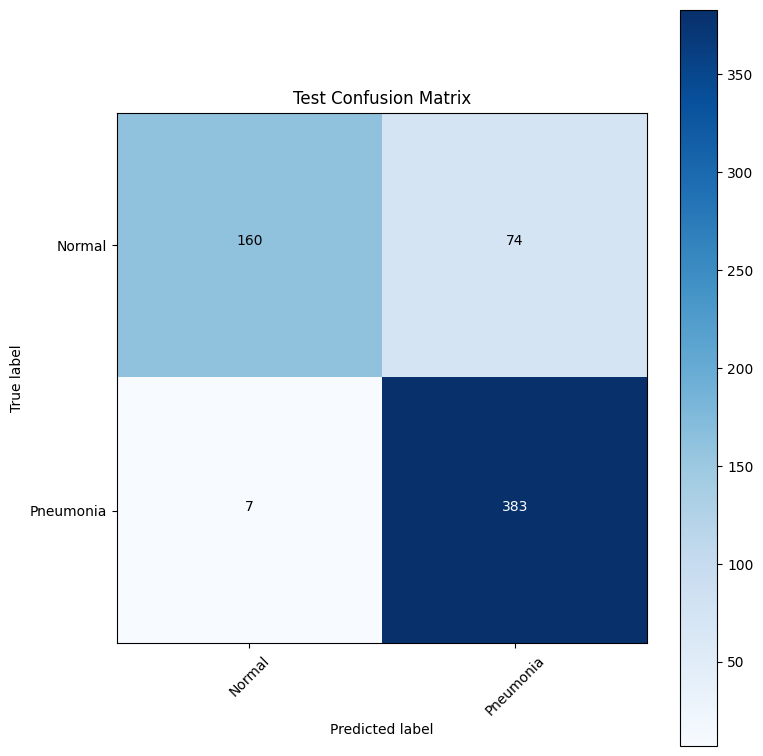

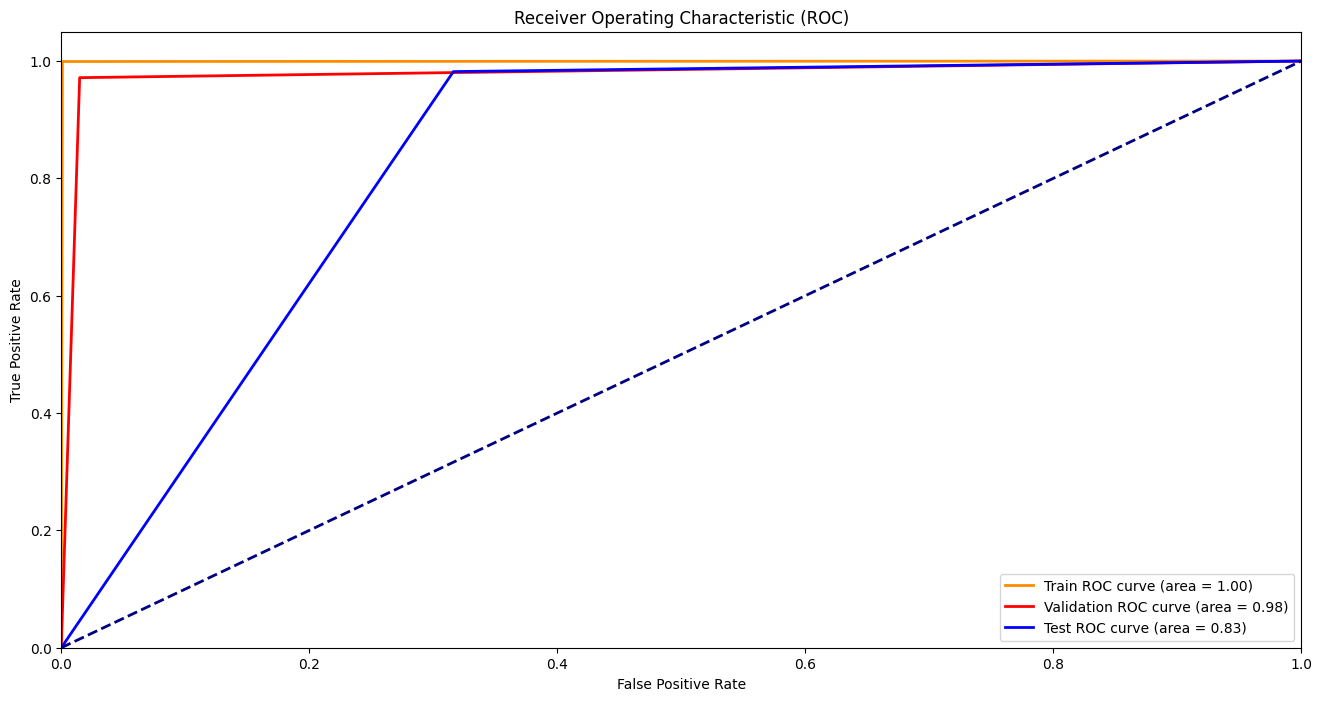

In [34]:
# Doing the same for the ensemble model

TRAIN_CM, VAL_CM, TEST_CM, FPR, TPR, ROC_AUC, FPR_VAL, TPR_VAL, ROC_AUC_VAL, FPR_TEST, TPR_TEST, ROC_AUC_TEST = get_metrics(ENSEMBLE, X_TRAIN, X_VAL, X_TEST, Y_TRAIN, Y_VAL, Y_TEST)

plot_confusion_matrix(TRAIN_CM, ['Normal', 'Pneumonia'], title='Train Confusion Matrix')
plot_confusion_matrix(VAL_CM, ['Normal', 'Pneumonia'], title='Validation Confusion Matrix')
plot_confusion_matrix(TEST_CM, ['Normal', 'Pneumonia'], title='Test Confusion Matrix')

plot_roc_curve(FPR, TPR, ROC_AUC, FPR_VAL, TPR_VAL, ROC_AUC_VAL, FPR_TEST, TPR_TEST, ROC_AUC_TEST)

In [35]:

# Save the models
INCEPRESNET.save('INCEPRESNET.keras')
ENSEMBLE.save('ensemble_model7_2_1.keras')